<a href="https://colab.research.google.com/github/joyce410star/silva--pure-website/blob/main/%E3%80%8CCODE%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#資料解壓縮
import zipfile

with zipfile.ZipFile("dataset-resized.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

In [24]:
#讀取圖片 + 調整大小 + 正規化 + 建立標籤
import os
from PIL import Image
import numpy as np

# ✅ 根據你的資料夾名稱設定正確路徑
data_dir = "data/dataset-resized"
categories = [c for c in os.listdir(data_dir) if not c.startswith('.')]
image_size = (128, 128)

X = []
y = []

for idx, category in enumerate(categories):
    folder = os.path.join(data_dir, category)
    for file in os.listdir(folder):
        img_path = os.path.join(folder, file)

        # ✅ 避免讀入非圖片檔案
        if not (file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")):
            continue

        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(image_size)
            img_array = np.array(img) / 255.0

            if img_array.shape == (128, 128, 3):
                X.append(img_array)
                y.append(idx)
            else:
                print(f"⚠️ 略過非 RGB 圖片：{img_path}")

        except Exception as e:
            print(f"❌ 錯誤圖片：{img_path}，錯誤：{e}")
            continue

X = np.array(X)
y = np.array(y)

print("✅ 圖片讀取完成！")
print("圖片資料維度：", X.shape)
print("標籤資料維度：", y.shape)
print("類別對應：", dict(enumerate(categories)))


✅ 圖片讀取完成！
圖片資料維度： (2527, 128, 128, 3)
標籤資料維度： (2527,)
類別對應： {0: 'plastic', 1: 'glass', 2: 'trash', 3: 'paper', 4: 'cardboard', 5: 'metal'}


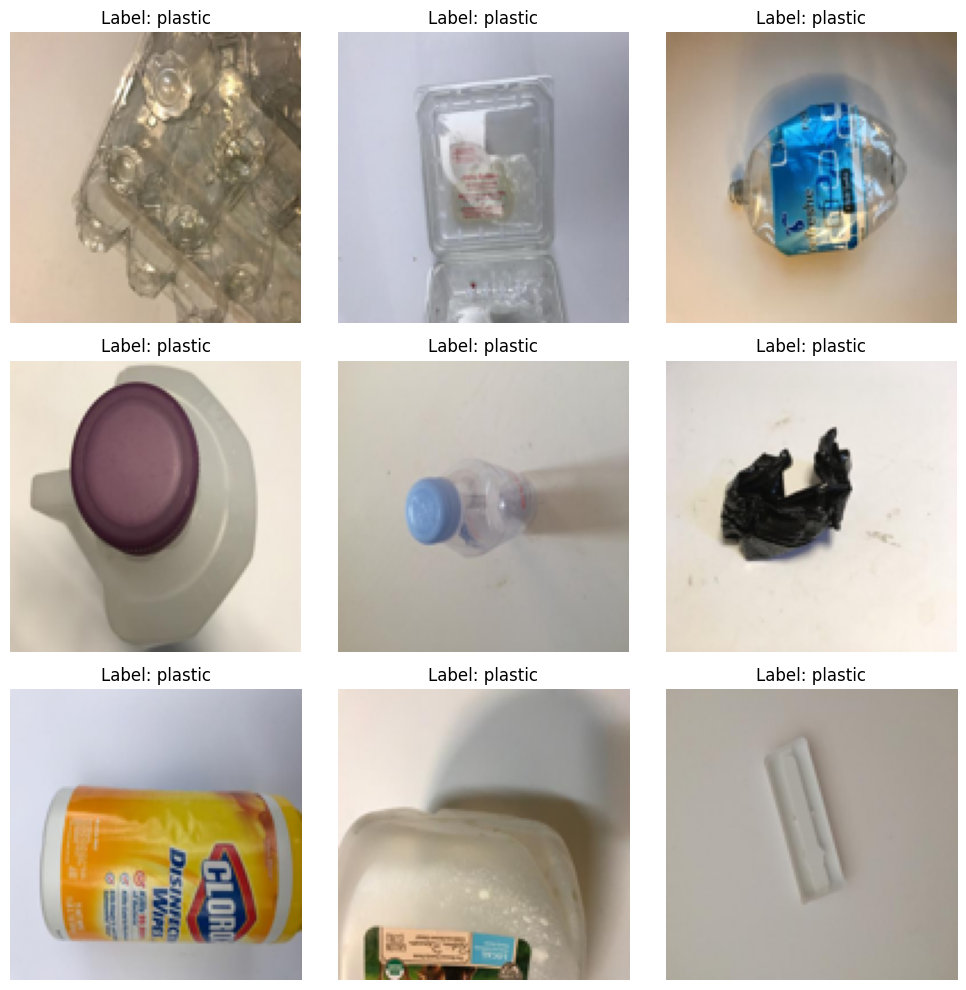

In [25]:
#顯示資料內前9張圖片
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i])
    plt.title(f"Label: {categories[y[i]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGRAPH-5404}) missing from font(s) DejaVu Sans.
  fig.canvas

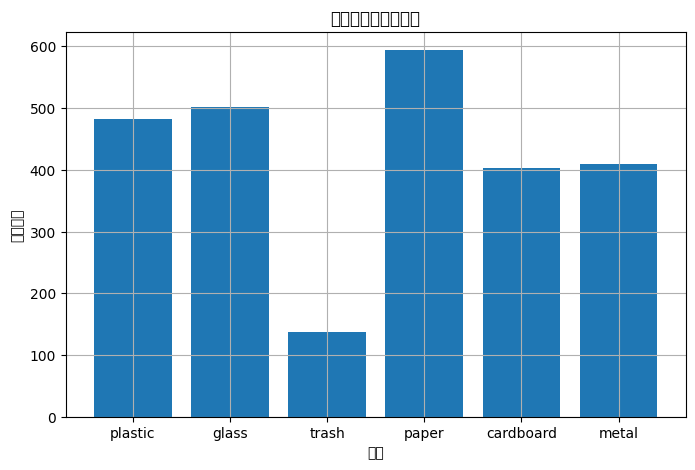

In [26]:
#類別數量統計圖
import matplotlib.pyplot as plt
import collections

# 計算每個類別的圖片數量
counter = collections.Counter(y)
category_names = [categories[i] for i in range(len(categories))]

plt.figure(figsize=(8, 5))
plt.bar(category_names, [counter[i] for i in range(len(categories))])
plt.title("各類別圖片數量分布")
plt.ylabel("圖片數量")
plt.xlabel("類別")
plt.grid(True)
plt.show()


In [27]:
#資料切分與類別編碼（訓練集/測試集）
#把資料切成 訓練集 和 測試集（80%/20% 比例）。
#把 y 轉成 one-hot 編碼（因為 CNN 輸出是 softmax）。

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 切分訓練集與測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# One-hot 編碼標籤
num_classes = len(categories)
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print("✅ 訓練集圖片維度：", X_train.shape)
print("✅ 測試集圖片維度：", X_test.shape)
print("✅ One-hot 標籤維度：", y_train_cat.shape)


✅ 訓練集圖片維度： (2021, 128, 128, 3)
✅ 測試集圖片維度： (506, 128, 128, 3)
✅ One-hot 標籤維度： (2021, 6)


In [43]:
# 1. 載入必要模組
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # 👈 Dropout 加進來！

# 2. 定義類別數（根據你資料夾）
num_classes = 6

# 3. 建立 CNN 模型
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),  # 新增第三層
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(256, activation='relu'),  # 全連接層也加大一點
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])



In [44]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # 對應 one-hot
    metrics=['accuracy']
)


In [45]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=3,          # 若3次沒進步就停
    restore_best_weights=True
)


In [46]:
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=10,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 723ms/step - accuracy: 0.2576 - loss: 1.7373 - val_accuracy: 0.4249 - val_loss: 1.3886
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 712ms/step - accuracy: 0.4256 - loss: 1.3856 - val_accuracy: 0.4802 - val_loss: 1.2946
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 46s 722ms/step - accuracy: 0.5015 - loss: 1.2613 - val_accuracy: 0.5791 - val_loss: 1.1469
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 43s 668ms/step - accuracy: 0.5648 - loss: 1.1205 - val_accuracy: 0.5988 - val_loss: 1.0668
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 80s 640ms/step - accuracy: 0.6295 - loss: 1.0057 - val_accuracy: 0.5692 - val_loss: 1.1461
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 685ms/step - accuracy: 0.6369 - loss: 0.9909 - val_accuracy: 0.5652 - val_loss: 1.1494
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 693ms/step - accuracy: 0.6625 - loss: 0.9151 - val_accuracy: 0.6304 - val_loss: 0.9883
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 679ms/step - accuracy: 0.7505 - loss: 0.7284 - val_accu

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

# 替代 model.fit() 使用 fit_generator
history = model.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),
    validation_data=(X_test, y_test_cat),
    epochs=20,
    callbacks=[early_stop]
)


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 747ms/step - accuracy: 0.5632 - loss: 1.1843 - val_accuracy: 0.6364 - val_loss: 0.9889
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 742ms/step - accuracy: 0.5814 - loss: 1.0912 - val_accuracy: 0.6601 - val_loss: 0.9536
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 779ms/step - accuracy: 0.6597 - loss: 0.9788 - val_accuracy: 0.5830 - val_loss: 1.0487
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 746ms/step - accuracy: 0.6412 - loss: 1.0016 - val_accuracy: 0.6759 - val_loss: 0.8916
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 47s 740ms/step - accuracy: 0.6528 - loss: 0.9480 - val_accuracy: 0.7075 - val_loss: 0.8319
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 48s 751ms/step - accuracy: 0.6805 - loss: 0.8925 - val_accuracy: 0.6640 - val_loss: 0.9375
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - accuracy: 0.6733 - loss: 0.9118 - val_accuracy: 0.6976 - val_loss: 0.7917
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 780ms/step - accuracy: 0.7039 - loss: 0.8186 - val_accu

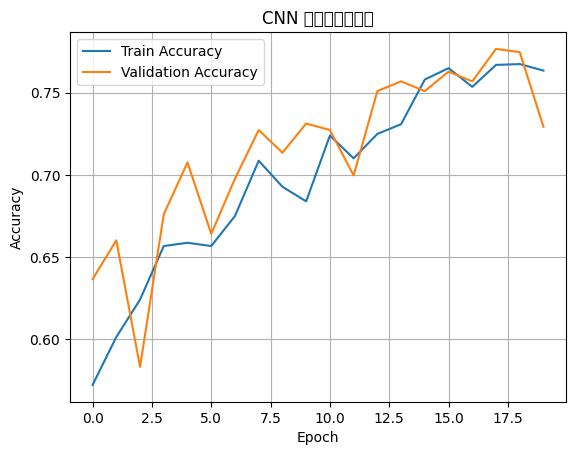

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN 模型準確率變化')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
from google.colab import files
uploaded = files.upload()


Saving CC.2.jpg to CC.2 (1).jpg


In [50]:
from PIL import Image
import numpy as np

def predict_image(image_path, model, categories):
    # 讀入圖片
    img = Image.open(image_path).convert("RGB")
    img = img.resize((128, 128))  # 對應你模型的輸入大小

    # 正規化
    img_array = np.array(img) / 255.0
    img_array = img_array.reshape((1, 128, 128, 3))  # 增加 batch 維度

    # 預測
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    predicted_label = categories[predicted_class]

    # 顯示結果
    print(f"✅ 預測結果：{predicted_label}（信心值：{predictions[0][predicted_class]:.2f}）")

    # 顯示圖片
    import matplotlib.pyplot as plt
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
✅ 預測結果：cardboard（信心值：0.50）


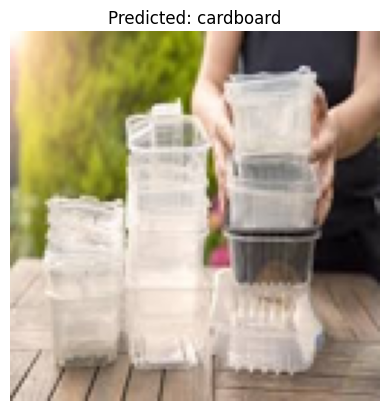

In [51]:
predict_image("CC.2.jpg", model, categories)
